<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/SaliencyMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

data_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database'




 **Create directories for training and validation data**

In [6]:
train_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_train'
validation_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

##  Create class subdirectories in training and validation directories

In [7]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Create class subdirectories in training and validation directories
class_names = ['Tuberculosis', 'Normal']  # Adjust class names accordingly
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

In [11]:
class_names = ['Tuberculosis', 'Normal']
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


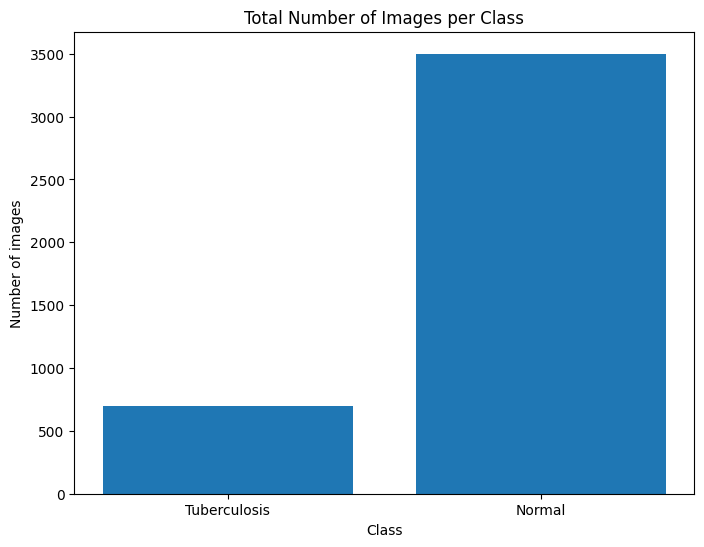

In [12]:
# Convert labels to numeric format
label_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
labels = np.array([label_dict[label] for label in labels])

# Plot total number of images per class
def plot_distribution(data, title):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, [np.sum(data == label_dict[class_name]) for class_name in class_names])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

# Plot initial distribution of images
plot_distribution(labels, 'Total Number of Images per Class')

## Split data into training and validation sets

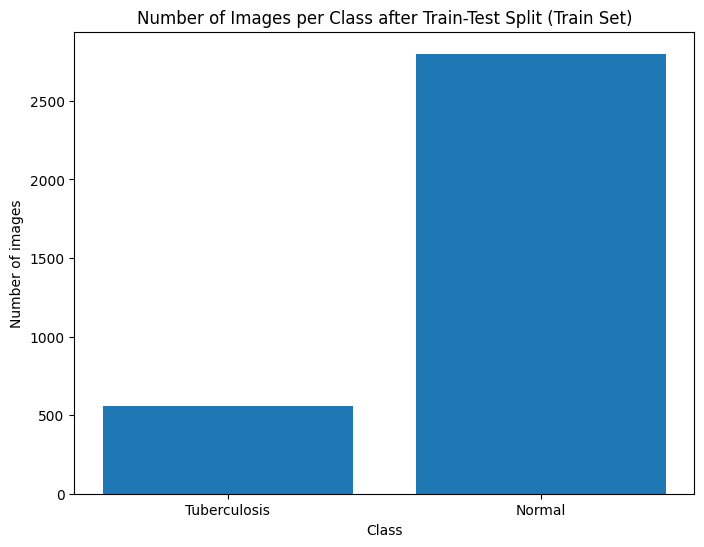

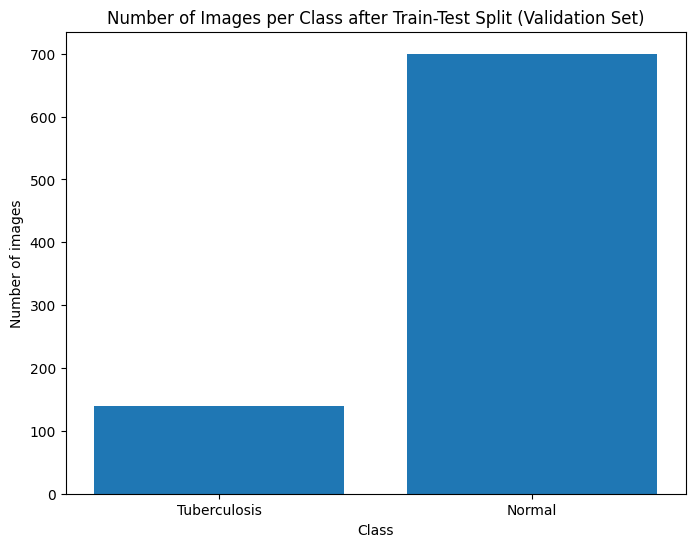

In [13]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Plot distribution of images after train-test split
plot_distribution(train_labels, 'Number of Images per Class after Train-Test Split (Train Set)')
plot_distribution(val_labels, 'Number of Images per Class after Train-Test Split (Validation Set)')


# Apply random undersampling to balance the classes in the training set

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


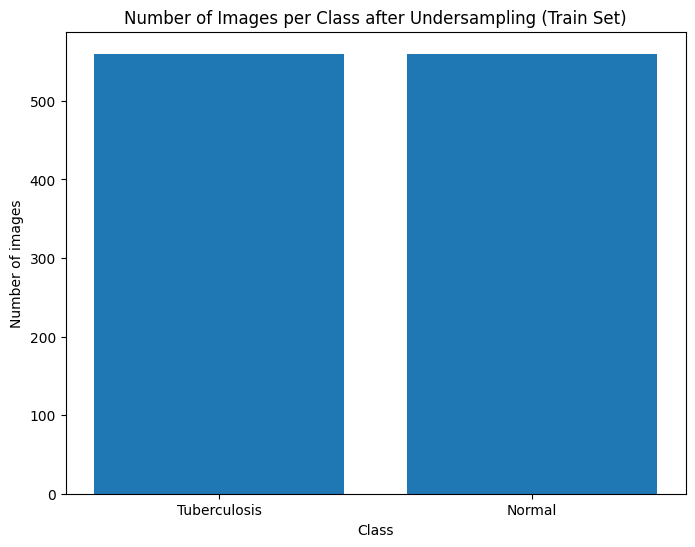

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


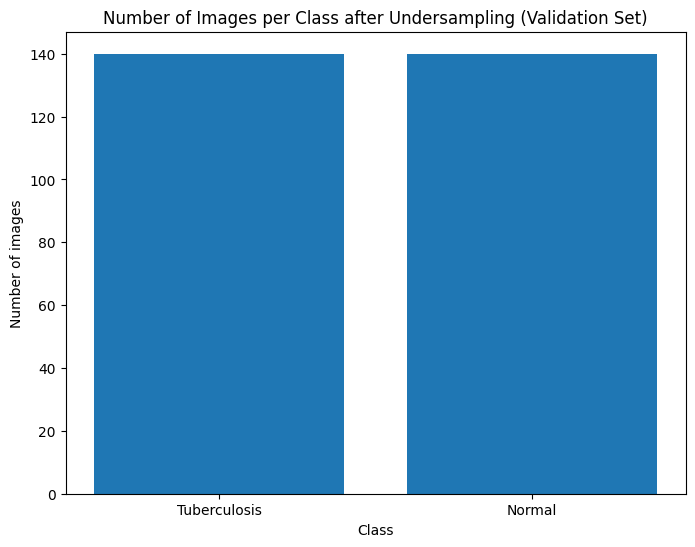

In [14]:
# Plot distribution of images after undersampling
rus = RandomUnderSampler()
train_paths, train_labels = rus.fit_resample(np.array(train_paths).reshape(-1, 1), train_labels)
train_paths = train_paths.flatten()
plot_distribution(train_labels, 'Number of Images per Class after Undersampling (Train Set)')
# Apply random undersampling to balance the classes in the validation set
val_paths, val_labels = rus.fit_resample(np.array(val_paths).reshape(-1, 1), val_labels)
val_paths = val_paths.flatten()
plot_distribution(val_labels, 'Number of Images per Class after Undersampling (Validation Set)')




In [ ]:
# Copy images to respective directories and count them
def copy_images(image_paths, labels, target_dir):
    count = {class_name: 0 for class_name in class_names}
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        target_class_dir = os.path.join(target_dir, class_name)
        shutil.copy(img_path, target_class_dir)
        count[class_name] += 1
    return count

train_count = copy_images(train_paths, train_labels, train_dir)
val_count = copy_images(val_paths, val_labels, validation_dir)

print("Number of images copied for training after undersampling:")
print(train_count)

print("Number of images copied for validation after undersampling:")
print(val_count)





Number of images copied for training after undersampling:
{'Tuberculosis': 560, 'Normal': 560}
Number of images copied for validation after undersampling:
{'Tuberculosis': 140, 'Normal': 140}


## transfer learning with dense121

In [15]:
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(224, 224, 3))

# Add custom layers on top of the base model for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (1 output unit with sigmoid activation)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [16]:
# Prepare data generators for training and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing the training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = True)  # Binary classification

validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # Directory containing the validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


## training

In [17]:
 model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Reduce steps per epoch
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Reduce validation steps
    epochs=1,  # Keep it low

)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 0.8899 - loss: 0.3157 - val_accuracy: 0.9805 - val_loss: 0.0877


In [ ]:
model.save("/content/drive/MyDrive/Models/CNNmetrics.h5")


## Evaluating the model

9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       140
Tuberculosis       0.98      0.99      0.98       140

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280



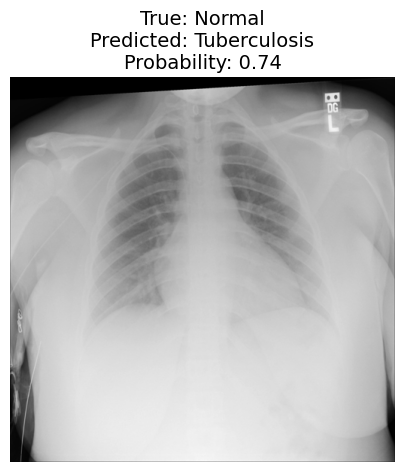

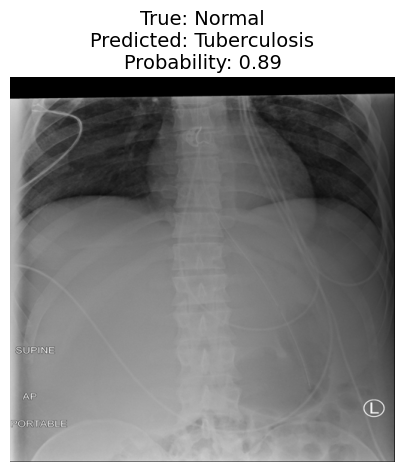

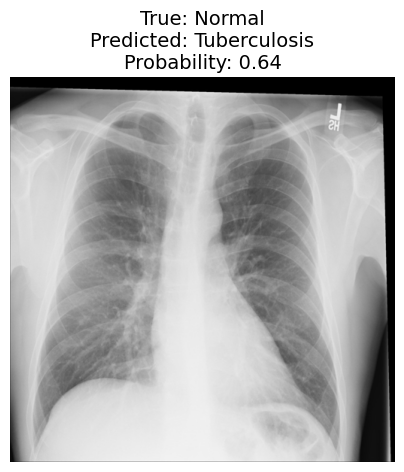

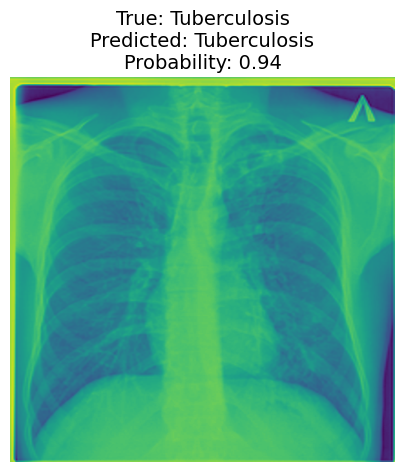

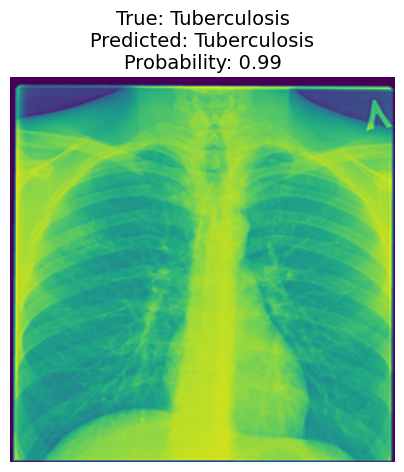

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the label names corresponding to the model's output classes
LABELS = ["Normal", "Tuberculosis"]

# Predict the classes for the validation set
val_preds = model.predict(validation_generator)
val_preds_class = (val_preds > 0.5).astype(int)  # Convert probabilities to binary classes

# Get the true labels and image file paths
val_true_labels = validation_generator.classes
val_image_paths = validation_generator.filepaths  # File paths for validation images

# Print classification report
print(classification_report(val_true_labels, val_preds_class, target_names=LABELS))

# Display only images classified as Tuberculosis
def display_tuberculosis_predictions(num_images=5):
    count = 0  # Counter for images displayed

    for i in range(len(val_preds_class)):
        if val_preds_class[i][0] == 1:  # Check if classified as Tuberculosis
            img_path = val_image_paths[i]
            true_label = LABELS[val_true_labels[i]]
            predicted_label = LABELS[val_preds_class[i][0]]
            prediction_value = val_preds[i][0]

            # Load and preprocess the image for display
            img = plt.imread(img_path)

            # Plot the image with true and predicted labels, and prediction value
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('Off')
            plt.title(f"True: {true_label}\nPredicted: {predicted_label}\nProbability: {prediction_value:.2f}", fontsize=14)
            plt.show()

            count += 1
            if count == num_images:  # Stop after displaying the specified number of images
                break

# Show predictions for images classified as Tuberculosis
display_tuberculosis_predictions(num_images=5)





In [19]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
true_classes = validation_generator.classes
print("Classification Report:")
print(classification_report(true_classes, val_preds_class))
true_classes = true_classes[:len(val_preds_class)]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       140
           1       0.98      0.99      0.98       140

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280



## Accuracy plotting

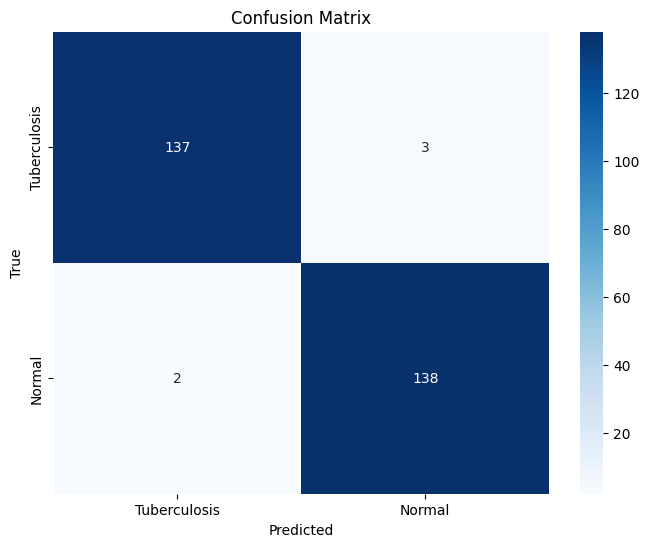

In [20]:
import seaborn as sns
# Compute the classification report
val_labels_true = validation_generator.classes
# Plot confusion matrix
conf_matrix = confusion_matrix(val_labels_true, val_preds_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step


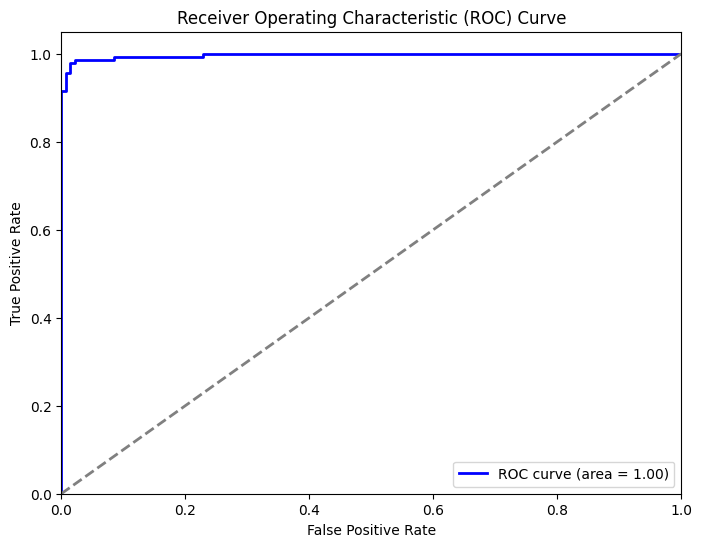

In [21]:
# Plot AUC-ROC curve
val_preds_prob = model.predict(validation_generator)
fpr, tpr, _ = roc_curve(val_labels_true, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<ipython-input-74-3db45e5f0606>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  saliency_map = plt.cm.get_cmap(cmap)(saliency_map)[:, :, :3]  # Apply colormap and drop alpha channel


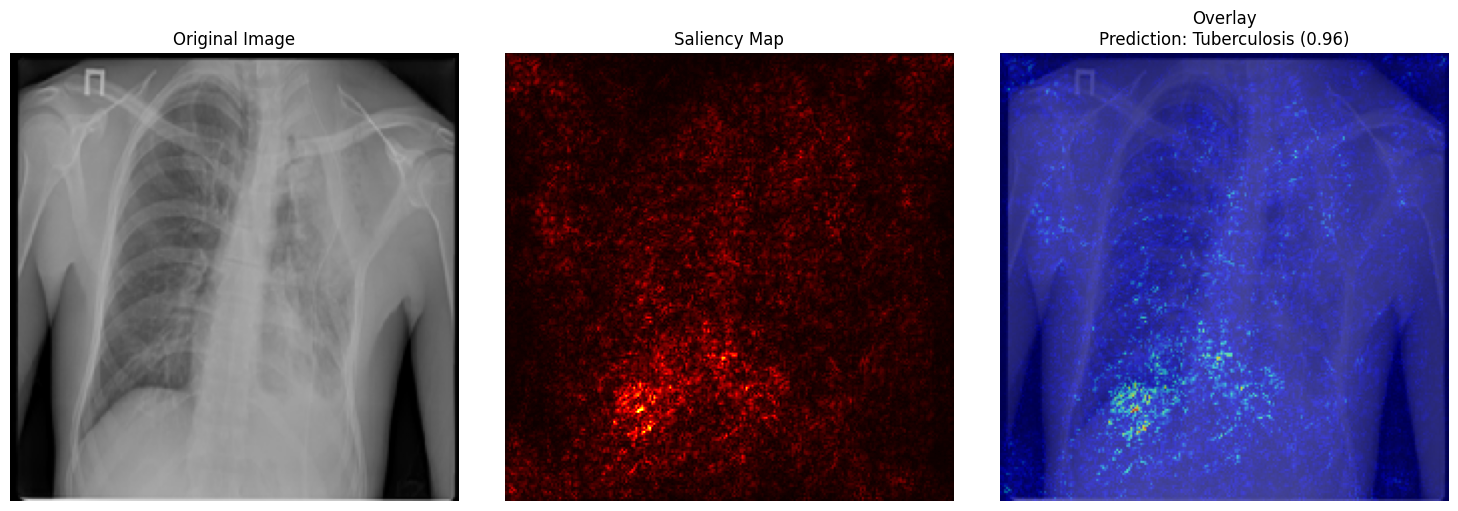

In [74]:
# Assuming `model` is your trained Keras model
# Example image path (replace with your test image path)
from tensorflow.keras.preprocessing import image

# Load and preprocess the test image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img

# Compute saliency map
def compute_saliency_map(model, input_image):
    input_image = tf.convert_to_tensor(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)  # Watch the input tensor
        predictions = model(input_image)
        predicted_class = tf.argmax(predictions[0])  # Get the predicted class index
        loss = predictions[0][predicted_class]  # Compute the loss for the predicted class

    # Compute gradients of the loss w.r.t. input image
    gradients = tape.gradient(loss, input_image)[0]

    # Compute the absolute value of gradients and normalize
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1).numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    return saliency, predictions.numpy()[0]

# Overlay the saliency map on the original image
def overlay_saliency_on_image(input_image, saliency_map, alpha=0.6, cmap='jet'):
    input_image = input_image[0]  # Remove batch dimension
    saliency_map = np.uint8(255 * saliency_map)  # Scale to [0, 255]
    saliency_map = plt.cm.get_cmap(cmap)(saliency_map)[:, :, :3]  # Apply colormap and drop alpha channel
    overlay = alpha * saliency_map + (1 - alpha) * input_image
    return overlay

# Visualization
def visualize_three_images(input_image, saliency_map, overlay, prediction):
    predicted_label = "Tuberculosis" if prediction[0] > 0.5 else "Normal"
    confidence = prediction[0] if prediction[0] > 0.5 else 1 - prediction[0]

    # Plot the original image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image[0])  # Original image
    plt.axis('off')
    plt.title("Original Image")

    # Plot the saliency map
    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='hot')  # Saliency map
    plt.axis('off')
    plt.title("Saliency Map")

    # Plot the overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Overlay\nPrediction: {predicted_label} ({confidence:.2f})")

    plt.tight_layout()
    plt.show()

# Load and preprocess the test image
test_image_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database_train/Tuberculosis/Tuberculosis-109.png" # Replace with your uploaded image path
input_image, raw_image = preprocess_image(test_image_path)

# Compute saliency map and prediction
saliency_map, prediction = compute_saliency_map(model, input_image)

# Create the overlay
overlay = overlay_saliency_on_image(input_image, saliency_map)

# Visualize all three images
visualize_three_images(input_image, saliency_map, overlay, prediction)

Calculation of Faithfulness

In [75]:
def compute_faithfulness(model, input_image, saliency_map, top_k=0.1):
    """
    Compute the Faithfulness metric for the saliency map.
    Faithfulness measures the change in model output after masking top-k% important pixels.
    This version ensures the returned Faithfulness value is always positive.
    """
    # Flatten saliency map and get indices of top-k% important pixels
    flattened_saliency = saliency_map.flatten()
    num_pixels = int(top_k * flattened_saliency.size)
    top_indices = np.argsort(flattened_saliency)[-num_pixels:]

    # Mask the top-k% pixels in the input image
    masked_image = input_image.copy()
    masked_image = masked_image.reshape(-1, masked_image.shape[-1])
    masked_image[top_indices, :] = 0  # Zero out the most important pixels
    masked_image = masked_image.reshape(input_image.shape)

    # Compute the change in prediction
    original_prediction = model(input_image).numpy()[0][0]
    masked_prediction = model(masked_image).numpy()[0][0]

    # Calculate faithfulness (ensure positive value)
    faithfulness = abs(original_prediction - masked_prediction)
    return faithfulness

Robustness

In [76]:
def compute_robustness(model, input_image, saliency_map, noise_std=0.01):
    # Add Gaussian noise to the input image
    noisy_image = input_image + np.random.normal(0, noise_std, input_image.shape)
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values are in [0, 1]

    # Compute new saliency map for the noisy image
    new_saliency_map, _ = compute_saliency_map(model, noisy_image)

    # Compute the similarity (e.g., Mean Absolute Difference)
    difference = np.mean(np.abs(saliency_map - new_saliency_map))
    return difference

Compactness

In [77]:
def compute_compactness(saliency_map, threshold=0.5):
    # Threshold the saliency map
    binary_map = saliency_map > threshold

    # Compute the ratio of the region size to the total image size
    compactness = np.sum(binary_map) / binary_map.size
    return compactness

Localization Accuracy

In [78]:
def compute_localization_accuracy(saliency_map, ground_truth_mask):
    # Normalize the saliency map
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    # Compute Intersection over Union (IoU)
    threshold = 0.5
    binary_saliency = saliency_map > threshold
    intersection = np.logical_and(binary_saliency, ground_truth_mask)
    union = np.logical_or(binary_saliency, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

Complexity

In [79]:
import time

def compute_complexity(model, input_image):
    start_time = time.time()
    saliency_map, _ = compute_saliency_map(model, input_image)
    end_time = time.time()
    complexity = end_time - start_time  # Time in seconds
    return complexity

In [80]:
faithfulness = compute_faithfulness(model, input_image, saliency_map)
robustness = compute_robustness(model, input_image, saliency_map)
compactness = compute_compactness(saliency_map)
localization_accuracy = compute_localization_accuracy(saliency_map, ground_truth_mask)
complexity = compute_complexity(model, input_image)

print("Metrics for Saliency Map:")
print(f"Faithfulness: {faithfulness:.4f}")
print(f"Robustness: {robustness:.4f}")
print(f"Compactness: {compactness:.4f}")
print(f"Localization Accuracy: {localization_accuracy:.4f}")
print(f"Complexity: {complexity:.4f} seconds")

Metrics for Saliency Map:
Faithfulness: 0.0408
Robustness: 0.0499
Compactness: 0.0008
Localization Accuracy: 0.0012
Complexity: 0.6837 seconds
